### Data Preparation

**Import Library**

In [3]:
# !pip install numpy
# !pip install numpy==1.26.0

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
sns.set_theme(style="whitegrid")
import matplotlib.dates as mdates

# !pip install keras-tuner
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import random

**Read the files**

In [6]:
set1 = pd.read_csv('../Data/SET_main.csv')

# This file is consist of data that have Nan values
set2 = pd.read_csv('../Data/SET_residual.csv')

sp500 = pd.read_csv('../Data/sp500_main.csv')

In [7]:
sp500 = sp500.set_index('Date')
sp500

,AAPL,AMZN,AVGO,COST,GOOG,GOOGL,HD,JPM,LLY,MA,META,MSFT,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
2014-01-02,17.234297,19.898500,3.961283,94.369179,27.624825,27.755241,63.568802,43.285351,40.585152,77.984024,54.545769,31.058565,0.373966,32.008656,58.940643,10.006667,63.013271,51.132057,21.054295,62.739441
2014-01-03,16.855730,19.822001,3.976331,93.952660,27.423307,27.552771,63.468048,43.619984,40.881153,77.672729,54.396221,30.849604,0.369486,31.923794,58.874783,9.970667,63.461128,51.166771,20.984922,62.588505
2014-01-06,16.947645,19.681499,3.949246,93.239731,27.729059,27.859968,62.855755,43.872814,41.225163,77.287491,57.028294,30.197683,0.374438,31.796507,59.013802,9.800000,62.734417,50.859058,20.867523,62.682835
2014-01-07,16.826441,19.901501,3.986865,92.807159,28.263626,28.397058,63.165791,43.367157,40.953148,78.364082,57.746128,30.431717,0.380568,32.118965,59.584633,9.957333,64.652641,51.247742,20.931564,63.569683
2014-01-08,16.933004,20.096001,4.046303,91.357330,28.322445,28.456152,63.499035,43.776134,40.889141,78.340698,58.055202,29.888441,0.385756,32.008652,58.721100,10.085333,63.900585,51.411995,20.766140,63.362122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05,243.039993,220.550003,170.470001,982.260010,174.112473,172.442368,426.540009,245.479996,825.619995,524.770020,608.929993,442.619995,145.059998,186.240005,176.029999,369.489990,576.757812,309.079987,95.300003,114.779999
2024-12-06,242.839996,227.029999,179.529999,992.609985,176.290009,174.510010,431.369995,247.360001,826.710022,528.570007,623.770020,443.570007,142.440002,191.690002,173.820007,389.220001,547.519958,311.010010,95.699997,113.570000
2024-12-09,246.750000,226.089996,178.940002,987.859985,177.100006,175.369995,429.179993,243.809998,803.580017,522.820007,613.570007,446.019989,138.809998,190.449997,170.789993,389.790009,560.619995,308.299988,93.830002,112.900002


In [8]:
sp500.shape

(2755, 20)

### Modeling 

**Data Preparation**

*Creating the function*

In [12]:
# Creating a function for data preparation 
def data_prep(df, stock_columns, test_size, window_size):
    results = {}
    
    for stock in stock_columns:
        print(f"Stock: {stock}")

        df.index = pd.to_datetime(df.index)
        
        # Plot training and test sets
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], df[stock][:-test_size], color='black', label="Training set")
        plt.plot(df.index[-test_size:], df[stock][-test_size:], color='blue', label="Test set")
        plt.title(f"{stock} Training and Test Sets", fontsize=15)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        
        # show only year
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())   
        plt.xlim(df.index.min(), df.index.max())
        plt.grid(color="lightgray")  
        plt.gca().set_facecolor("white") 
        plt.legend(loc="upper left")
        plt.tight_layout() 
        plt.show()

        # Scale the data 
        scaler = MinMaxScaler()
        
        # Window size (e.g., 30 days)
        window_size = window_size

        # Training set
        train_data = df[stock][:-test_size].values
        train_data = scaler.fit_transform(train_data.reshape(-1, 1))
        
        X_train, y_train = [], []
        for i in range(window_size, len(train_data)):
            X_train.append(train_data[i-window_size:i, 0])
            y_train.append(train_data[i, 0])
        
        # Testing set
        test_data = df[stock][-test_size-window_size:].values
        test_data = scaler.transform(test_data.reshape(-1, 1))
        
        X_test, y_test = [], []
        for i in range(window_size, len(test_data)):
            X_test.append(test_data[i-window_size:i, 0])
            y_test.append(test_data[i, 0])
        
        # Convert to numpy arrays to make it acceptable for the model
        X_train = np.array(X_train).reshape(-1, window_size, 1)
        X_test = np.array(X_test).reshape(-1, window_size, 1)
        y_train = np.array(y_train).reshape(-1, 1)
        y_test = np.array(y_test).reshape(-1, 1)

        print(f'{stock} - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}')
        print(f'{stock} - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}')
        
        # Store results
        results[stock] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test}
    
    return results


*Applying the function for sp500 (Stock exchange of Thailand)*

In [14]:
stock_columns = list(sp500.columns)
test_size = 360 
window_size = 60

Stock: AAPL


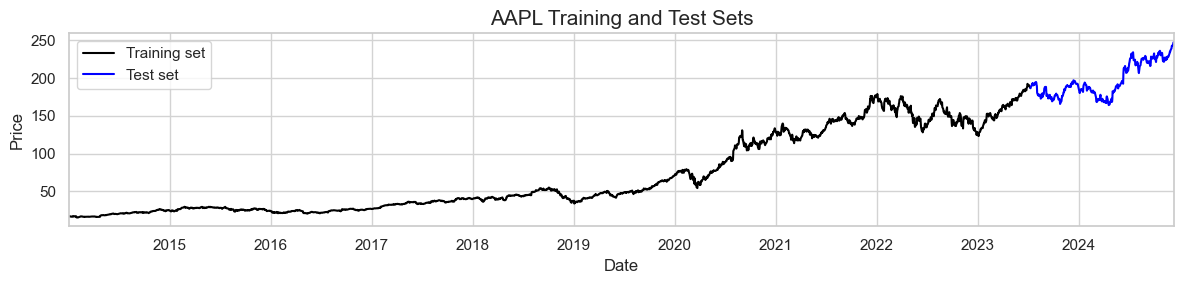

AAPL - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
AAPL - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: AMZN


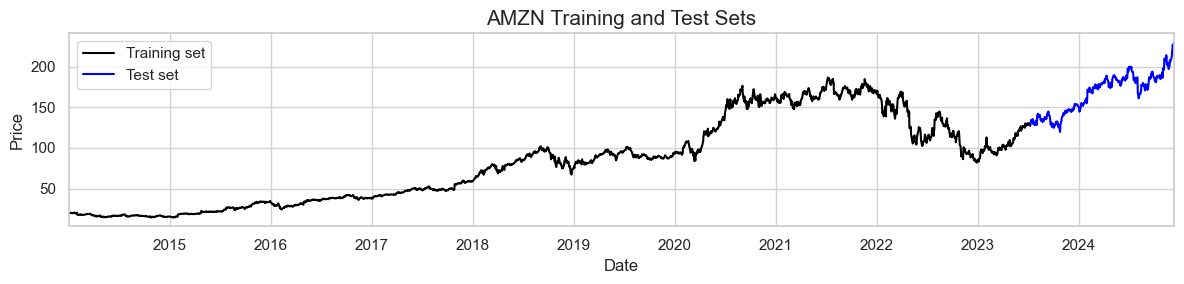

AMZN - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
AMZN - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: AVGO


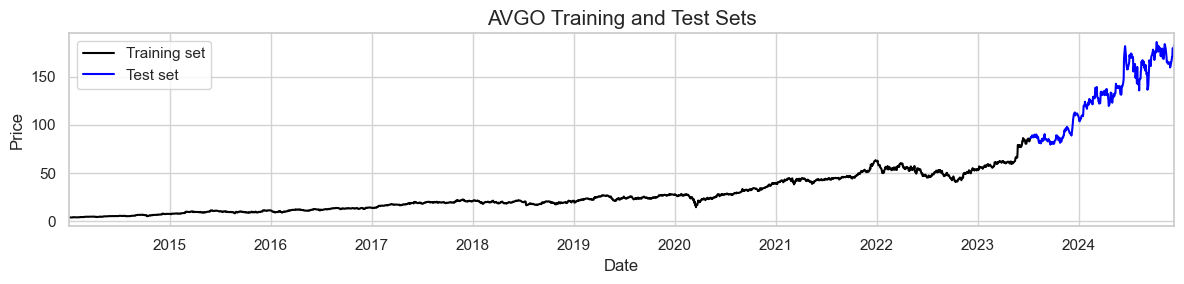

AVGO - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
AVGO - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: COST


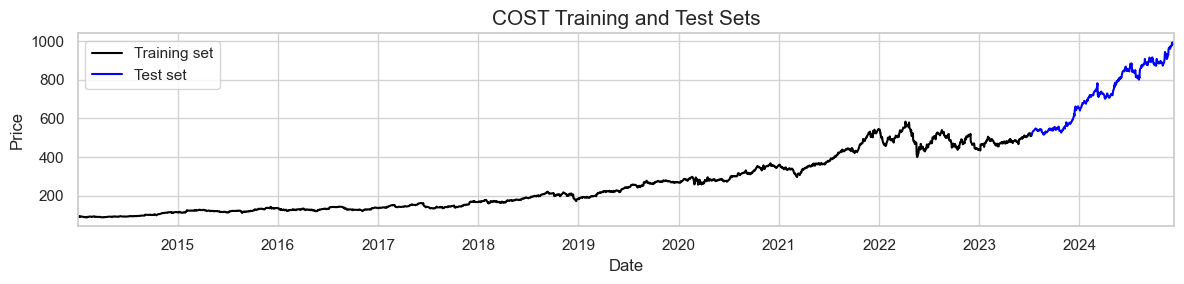

COST - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
COST - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: GOOG


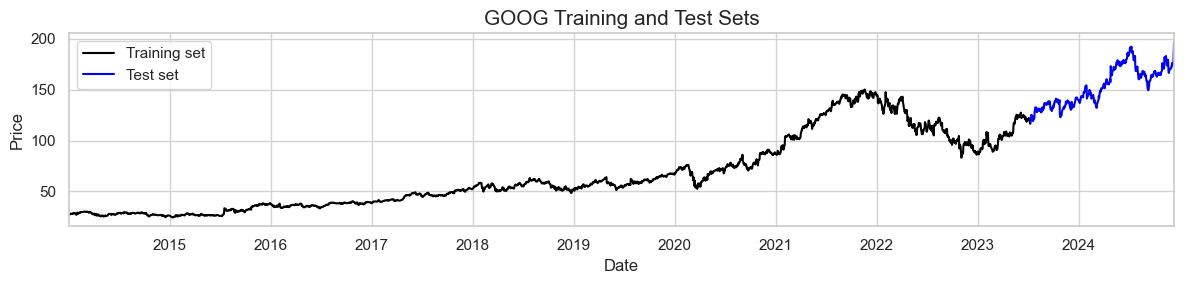

GOOG - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
GOOG - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: GOOGL


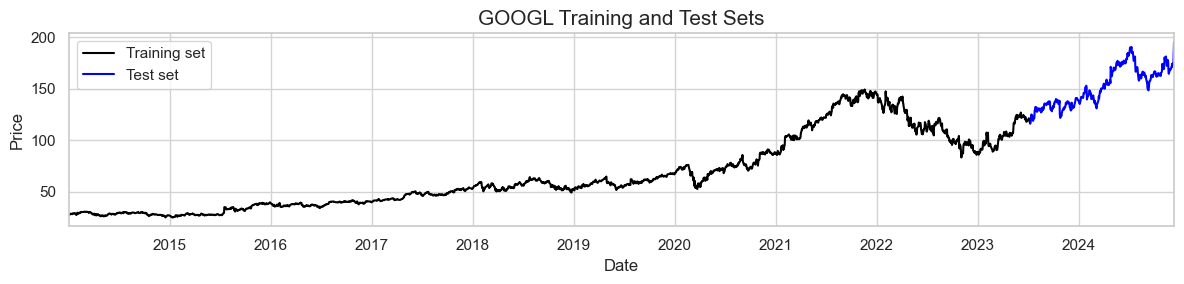

GOOGL - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
GOOGL - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: HD


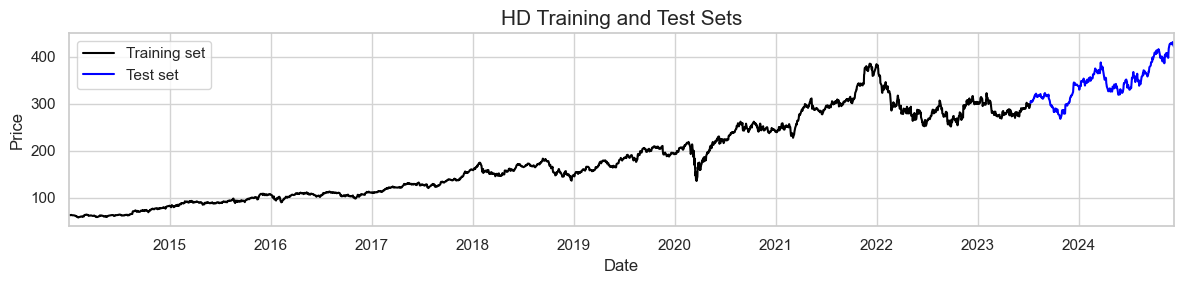

HD - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
HD - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: JPM


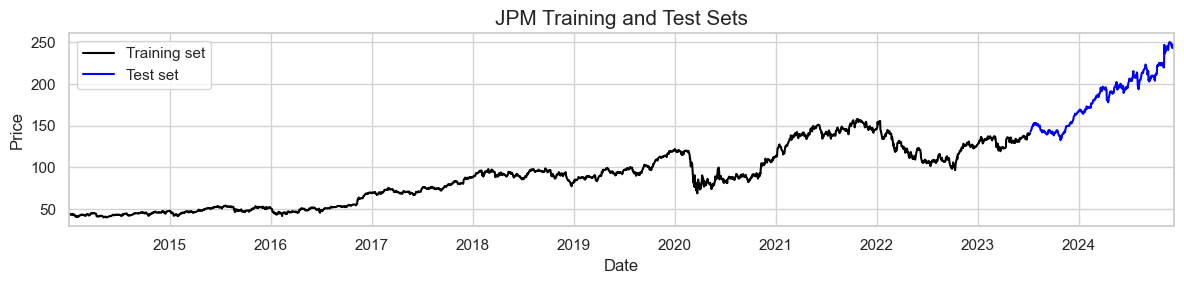

JPM - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
JPM - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: LLY


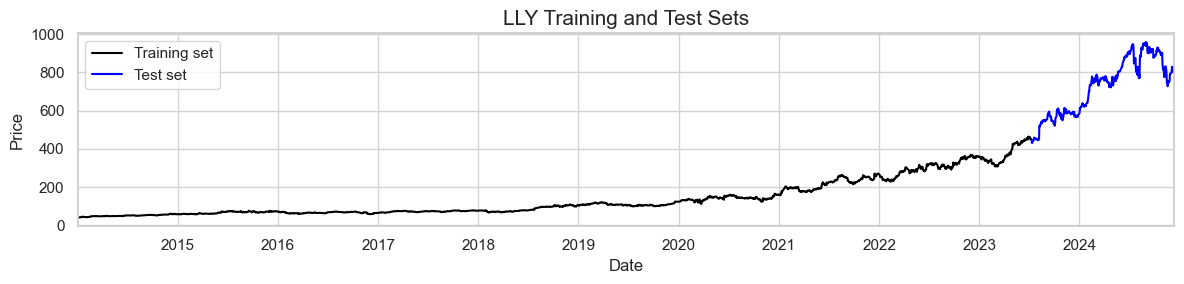

LLY - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
LLY - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: MA


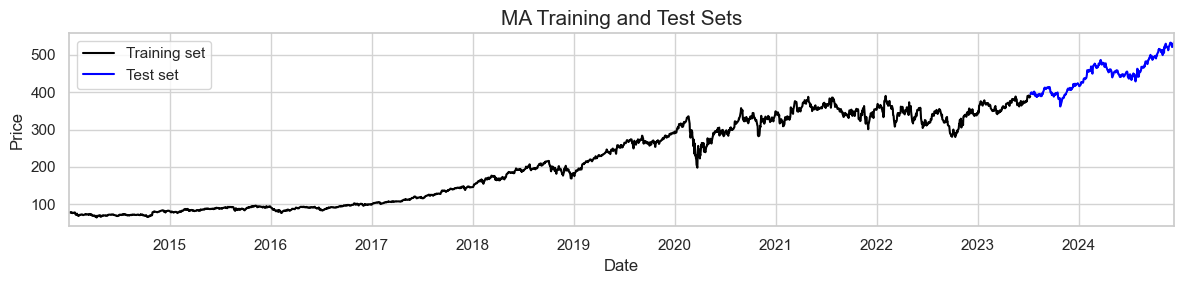

MA - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
MA - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: META


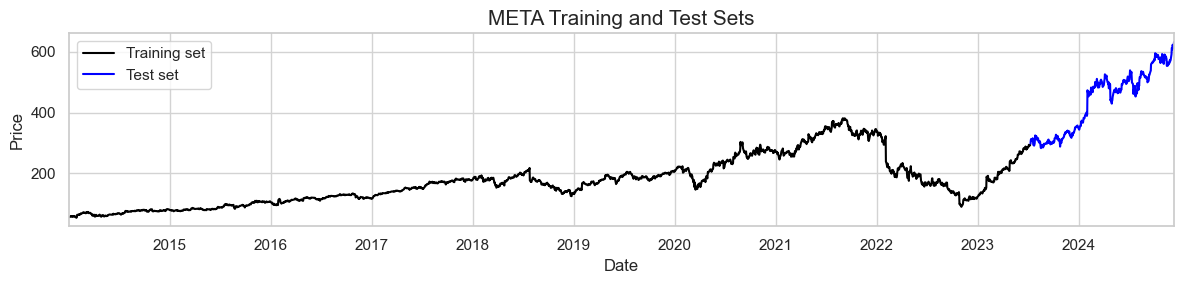

META - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
META - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: MSFT


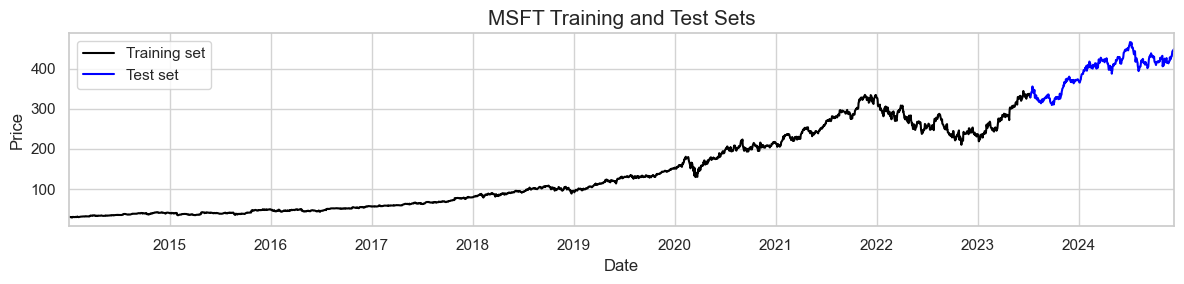

MSFT - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
MSFT - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: NVDA


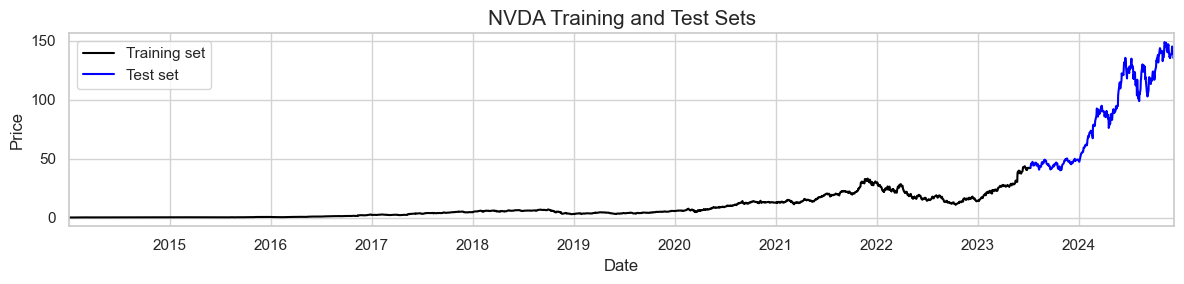

NVDA - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
NVDA - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: ORCL


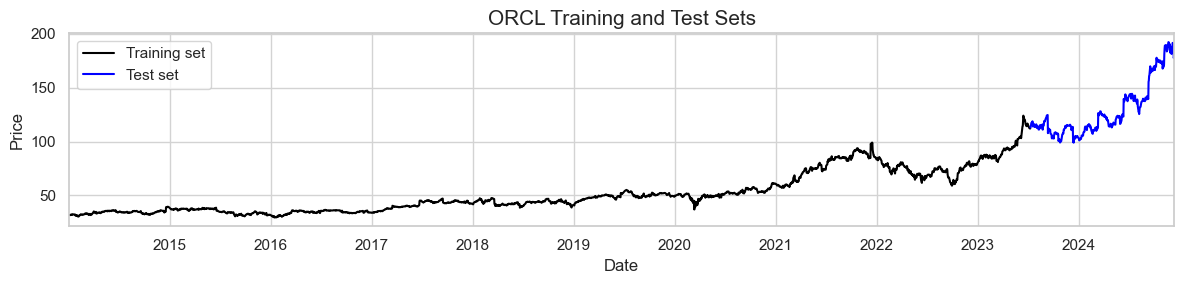

ORCL - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
ORCL - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PG


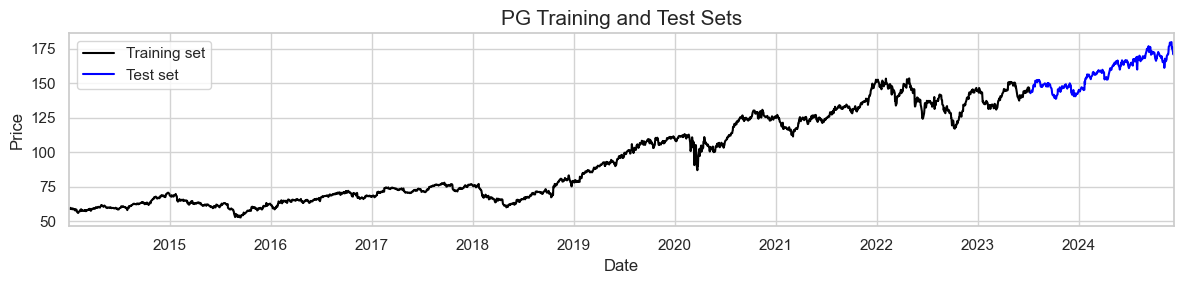

PG - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
PG - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TSLA


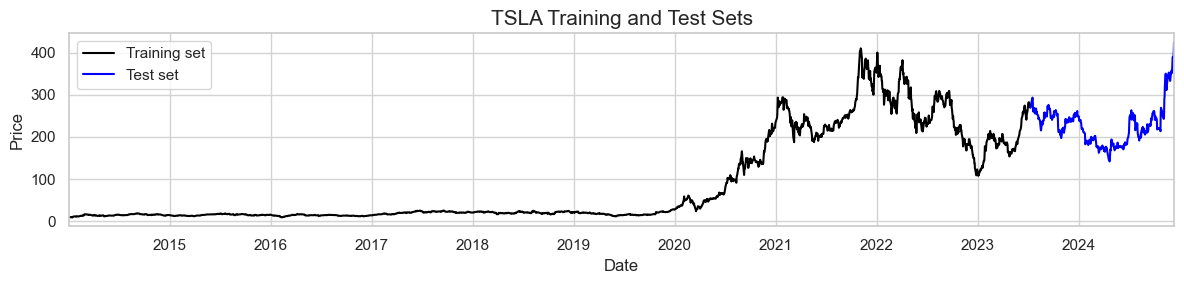

TSLA - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
TSLA - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: UNH


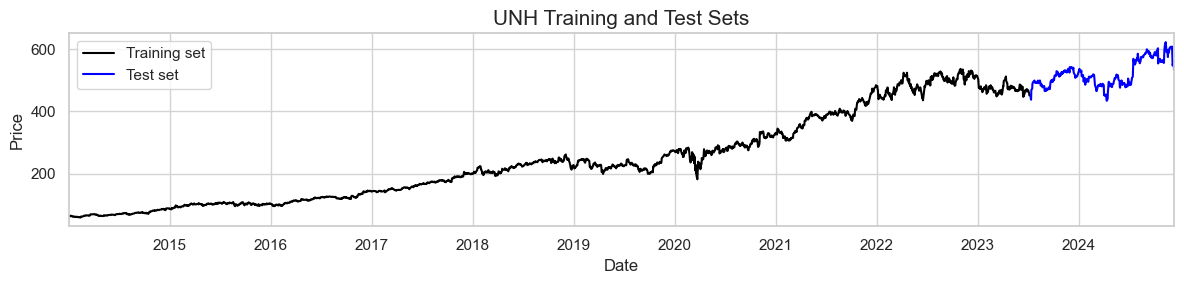

UNH - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
UNH - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: V


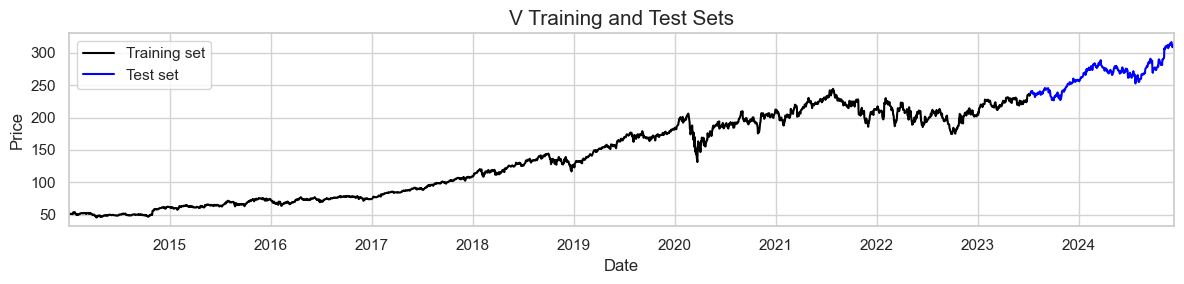

V - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
V - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: WMT


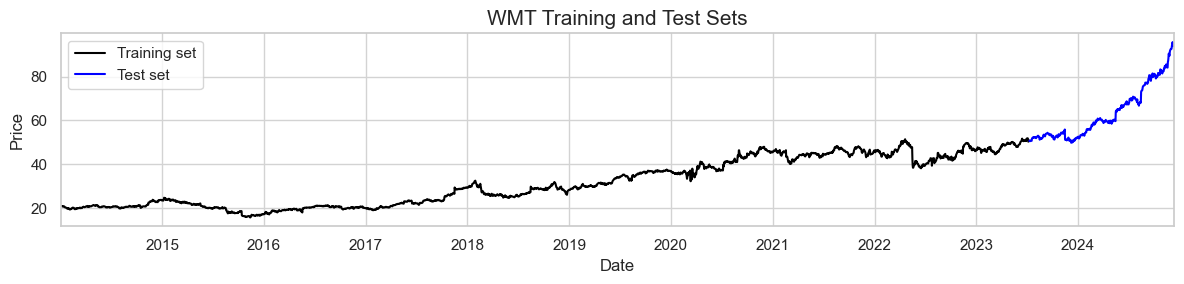

WMT - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
WMT - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: XOM


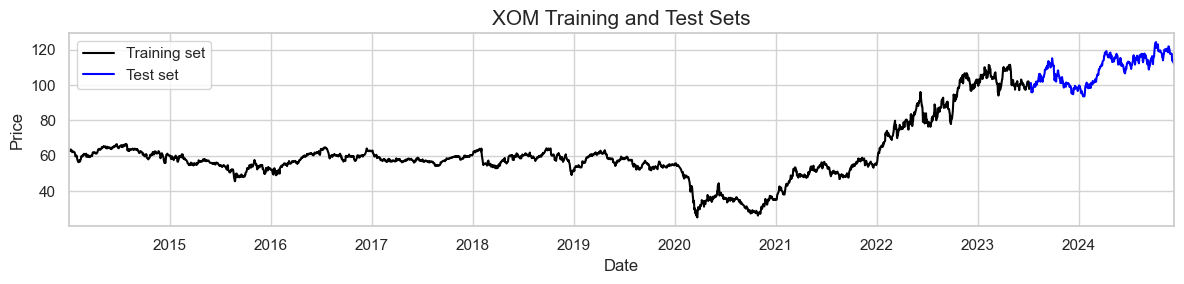

XOM - X_train Shape: (2335, 60, 1), y_train Shape: (2335, 1)
XOM - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)


In [15]:
# data preparation for dataframe sp500
# Adjusting the portfolio for 1 year time frame 
results = data_prep(df=sp500, stock_columns=stock_columns, test_size=test_size, window_size=window_size)

**Create function for LSTM model and Training**

*Create the model*

In [18]:
# Set random seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

def define_model(units_lstm_1, units_lstm_2, units_lstm_3, dropout_1, dropout_2, dropout_3, dense_units, optimizer_name):
    input1 = Input(shape=(window_size, 1))
    
    # First LSTM layer 
    x = LSTM(units=units_lstm_1, return_sequences=True)(input1)  
    x = Dropout(dropout_1)(x)
    
    # Second LSTM layer
    x = LSTM(units=units_lstm_2, return_sequences=True)(x)
    x = Dropout(dropout_2)(x)
    
    # Third LSTM layer
    x = LSTM(units=units_lstm_3)(x)
    x = Dropout(dropout_3)(x)
    
    # Dense layer with dynamic units
    x = Dense(dense_units, activation='relu')(x)
    
    # Output layer
    dnn_output = Dense(1)(x)

    # Map optimizer name to optimizer object
    optimizer_mapping = {
        'adam': Adam(),
        'nadam': Nadam(),
        'rmsprop': RMSprop()
    }
    optimizer = optimizer_mapping.get(optimizer_name, Adam())
    
    # Compile the model
    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.summary()
    
    return model

**Find the best hyperparameters**

In [20]:
# Function to Find the best hyperparameters
input1 = Input(shape=(window_size , 1))
def build_model(hp):
    # Tune the number of units in LSTM layers
    x = LSTM(units=hp.Int('units_layer_1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout_layer_3', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])

    # Tune the optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return model


In [21]:
# Loop through each column 
for stock in sp500.columns:
    # Recall X_train, X_test, y_train, y_test for each stock
    X_train = results[stock]['X_train']
    X_test = results[stock]['X_test']
    y_train = results[stock]['y_train']
    y_test = results[stock]['y_test']
    
    # Now you can use these variables (X_train, X_test, y_train, y_test) for further processing
    print(f"Processed {stock}: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Processed AAPL: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed AMZN: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed AVGO: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed COST: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed GOOG: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed GOOGL: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed HD: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed JPM: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed LLY: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed MA: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed META: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed MSFT: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed NVDA: X_train shape: (2335, 60, 1), X_test shape: (360, 60, 1)
Processed ORCL: X_train shape: (2335, 60, 1), X_test sha

In [22]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error', 
    max_trials=2,  
    executions_per_trial=1,  
    directory='tuner_results',
    project_name='lstm_tuning', 
    overwrite=True)
    

**Loop for all stocks name finding best hyperparameters, fit, and evaluate the model**

In [24]:
import time 
def find_fit_eva(df, test_size, results, tuner, define_model):
    # Start the timer for the entire process
    t0 = time.time()
    
    # Initialize dictionary to store hyperparameters + predictions + model
    hyperparameters_ = {}
    predictions_ = {}
    models_ = {}
    
    # Loop through each stock column in the dataframe
    for stock in df.columns:
        # Recall X_train, X_test, y_train, y_test for each stock
        X_train = results[stock]['X_train']
        X_test = results[stock]['X_test']
        y_train = results[stock]['y_train']
        y_test = results[stock]['y_test']
        
        # Hyperparameter tuning search for the current stock
        print(f"Starting tuning for {stock}...")
        tuner.search(X_train, y_train, 
                     epochs=50, 
                     batch_size=32, 
                     validation_split=0.2, 
                     verbose=1)
        
        # Get the best hyperparameters
        best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
        print(f"Best Hyperparameters for {stock}:\n {best_hyperparameters.values}")
    
        # Extract parameters values
        units_lstm_1 = best_hyperparameters['units_layer_1']
        units_lstm_2 = best_hyperparameters['units_layer_2']
        units_lstm_3 = best_hyperparameters['units_layer_3']
        dropout_1 = best_hyperparameters['dropout_layer_1']
        dropout_2 = best_hyperparameters['dropout_layer_2']
        dropout_3 = best_hyperparameters['dropout_layer_3']
        dense_units = best_hyperparameters['dense_units']
        optimizer_name = best_hyperparameters['optimizer']
    
        # Save the hyperparameters in a dictionary of DataFrames
        hyperparameters_dict = best_hyperparameters.values
        hyperparameters_[stock] = pd.DataFrame([hyperparameters_dict])
        print(hyperparameters_[stock].T) 
        
        # Define the model with the best hyperparameters
        model = define_model(units_lstm_1, units_lstm_2, units_lstm_3, dropout_1, dropout_2, dropout_3, dense_units, optimizer_name)
        
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
        
        # Evaluate the model
        print(f"\nEvaluating best model for {stock}")
        test_loss = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test) 
        print(f'Test loss for {stock}: {test_loss:.4f}')
    
        # Inverse transform predictions and true values
        scaler = MinMaxScaler()
        train_data = df[stock][:-test_size].values
        scaler.fit(train_data.reshape(-1, 1))  # Fit scaler only on training data
        y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_test_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        train_data = scaler.transform(train_data.reshape(-1, 1))

        # Store the predicted values for the stock
        predictions_[stock] = y_test_pred
        
        # Calculate evaluation metrics
        MSE = mean_squared_error(y_test_true, y_test_pred)
        RMSE = np.sqrt(MSE)
        print(f"Test MSE for {stock}: {MSE:.4f}")
        print(f"Test RMSE for {stock}: {RMSE:.4f}")

        df.index = pd.to_datetime(df.index)
        
        # Plot the prices predicted with actual
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], scaler.inverse_transform(train_data), color='black', label='Training Data')
        plt.plot(df.index[-test_size:], y_test_true, color='blue', label='Actual Test Data')
        plt.plot(df.index[-test_size:], y_test_pred, color='red', label='Predicted Test Data')
        plt.title(f'Model Performance on {stock} Prediction', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend(loc='upper left')
        plt.show()

        # Save the images
        plt.savefig(f'../images/{stock}_prediction_chart.png', format='png')

        # Store the model for this stock
        models_[stock] = model
        
    # Time to run in seconds for the entire process
    print(f"Total time taken for the entire process: {time.time() - t0} seconds")
    
    return hyperparameters_ , predictions_ , models_


Trial 2 Complete [00h 05m 28s]
val_mean_squared_error: 0.000662924547214061

Best val_mean_squared_error So Far: 0.000662924547214061
Total elapsed time: 00h 09m 39s
Best Hyperparameters for AAPL:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0169 - val_loss: 0.1166
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0029 - val_loss: 0.0485
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0021 - val_loss: 0.0276
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0015 - val_loss: 0.0233
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0010 - val_loss: 0.0187
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 9.1762e-04 - val_loss: 0.0142
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 8.6997e-04 - val_loss: 0.0102
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 8.7445e-04 - val_loss: 0.0095
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 6.4829e-04 - val_loss: 0.0159
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 7.2242e-04 - val_loss: 0.0110
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━

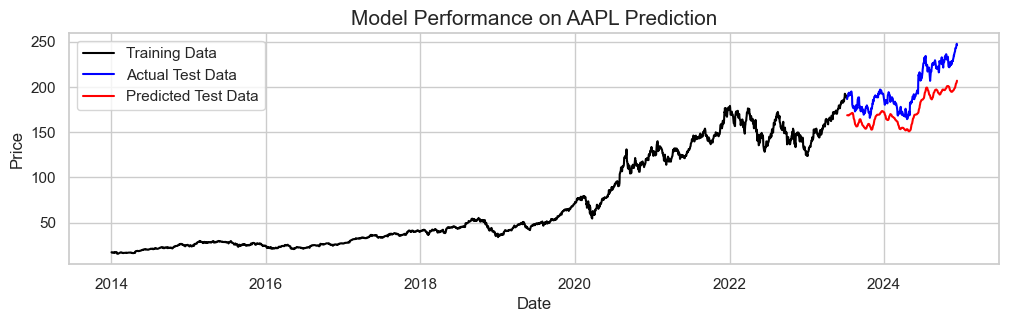

Starting tuning for AMZN...
Best Hyperparameters for AMZN:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0439 - val_loss: 0.0839
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0078 - val_loss: 0.0789
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0055 - val_loss: 0.0465
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0039 - val_loss: 0.0446
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0037 - val_loss: 0.0082
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0026 - val_loss: 0.0200
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0015 - val_loss: 0.0067
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0021 - val_loss: 0.0126
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0

<Figure size 640x480 with 0 Axes>

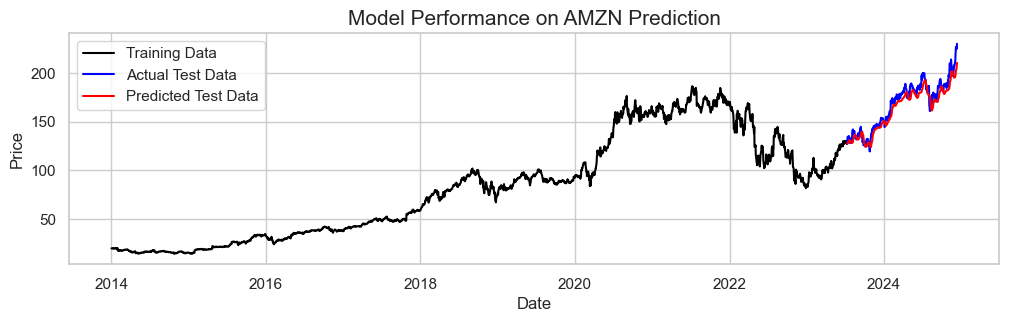

Starting tuning for AVGO...
Best Hyperparameters for AVGO:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0083 - val_loss: 0.0728
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0018 - val_loss: 0.0091
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0015 - val_loss: 0.0481
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0011 - val_loss: 0.0462
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 8.9668e-04 - val_loss: 0.0223
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 6.6490e-04 - val_loss: 0.0120
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 6.3496e-04 - val_loss: 0.0148
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 5.4464e-04 - val_loss: 0.0259
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 6.1172e-04 - val_loss: 0.0161
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 5.9089e-04 - val_loss: 0.0107
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 4.5149e-04 - val_loss: 0.0068
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

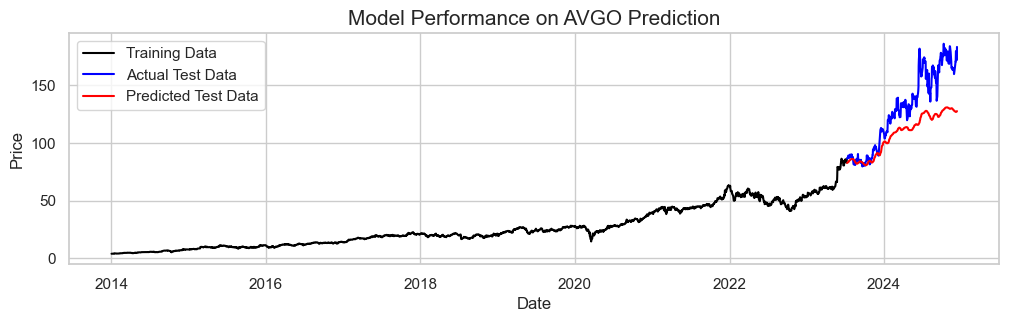

Starting tuning for COST...
Best Hyperparameters for COST:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0140 - val_loss: 0.1144
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.0030 - val_loss: 0.0407
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0019 - val_loss: 0.0271
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0011 - val_loss: 0.0245
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0010 - val_loss: 0.0209
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0010 - val_loss: 0.0408
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 8.0157e-04 - val_loss: 0.0269
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0010 - val_loss: 0.0114
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 6.4959e-04 - val_loss: 0.0081
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/s

<Figure size 640x480 with 0 Axes>

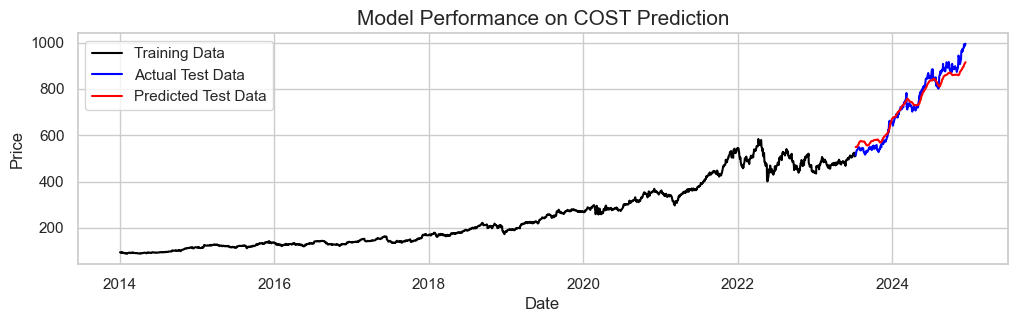

Starting tuning for GOOG...
Best Hyperparameters for GOOG:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0193 - val_loss: 0.0913
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0038 - val_loss: 0.0508
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0027 - val_loss: 0.0593
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0022 - val_loss: 0.0190
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0013 - val_loss: 0.0229
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0010 - val_loss: 0.0429
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0014 - val_loss: 0.0259
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0012 - val_loss: 0.0136
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0012 - val_loss: 0.0213
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 9.7390e-04 - val_loss: 0.0037
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 9.9569e-04 - val_loss: 0.0220
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step -

<Figure size 640x480 with 0 Axes>

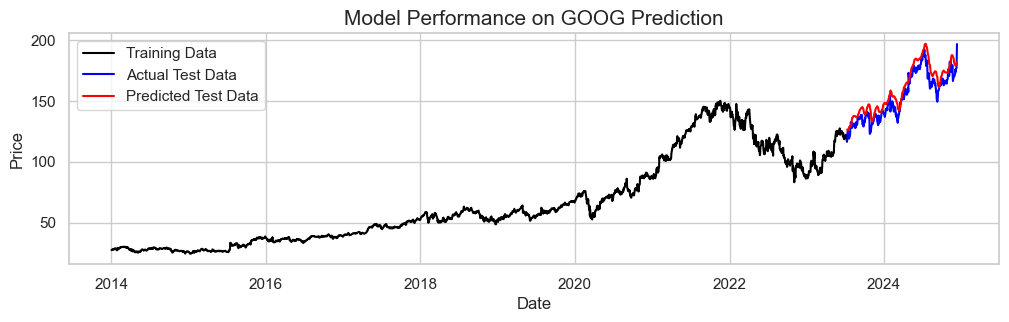

Starting tuning for GOOGL...
Best Hyperparameters for GOOGL:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0169 - val_loss: 0.0572
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0014 - val_loss: 0.1065
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0028 - val_loss: 0.0399
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0017 - val_loss: 0.0434
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0014 - val_loss: 0.0279
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0015 - val_loss: 0.0187
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 8.6978e-04 - val_loss: 0.0239
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 9.4417e-04 - val_loss: 0.0209
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 7.7542e-04 - val_loss: 0.0261
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7

<Figure size 640x480 with 0 Axes>

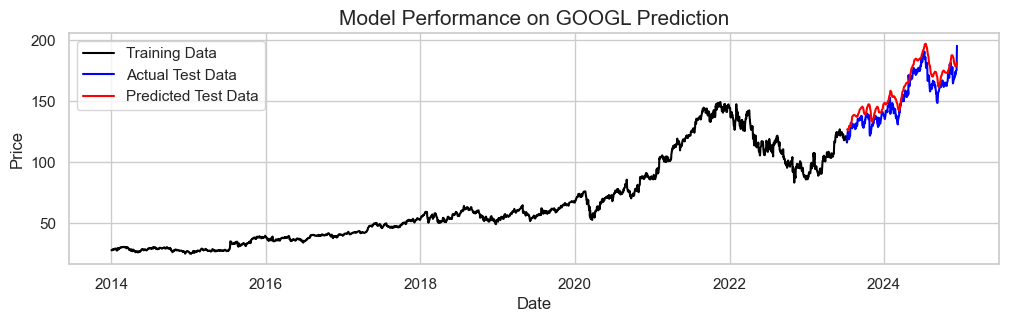

Starting tuning for HD...
Best Hyperparameters for HD:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0242 - val_loss: 0.0475
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0032 - val_loss: 0.0282
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0021 - val_loss: 0.0298
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0016 - val_loss: 0.0122
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0016 - val_loss: 0.0245
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0014 - val_loss: 0.0159
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0014 - val_loss: 0.0189
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 9.6465e-04 - val_loss: 0.0016
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/

<Figure size 640x480 with 0 Axes>

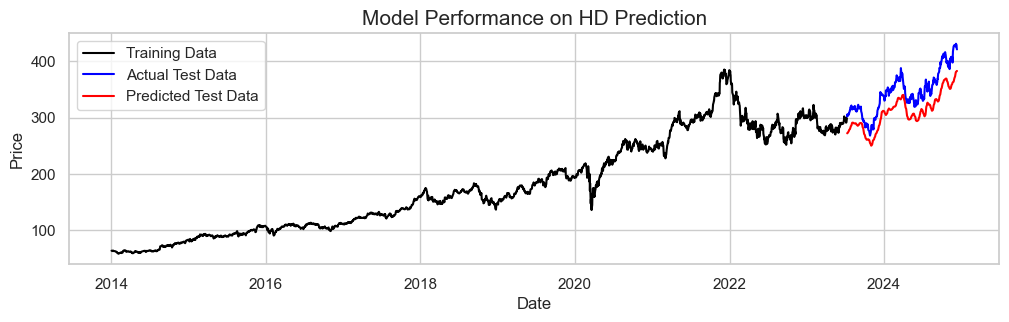

Starting tuning for JPM...
Best Hyperparameters for JPM:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0440 - val_loss: 0.0794
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0066 - val_loss: 0.1276
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0059 - val_loss: 0.0462
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0027 - val_loss: 0.0269
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0039 - val_loss: 0.0155
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0027 - val_loss: 0.0080
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0018 - val_loss: 0.0269
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0018 - val_loss: 0.0116
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - 

<Figure size 640x480 with 0 Axes>

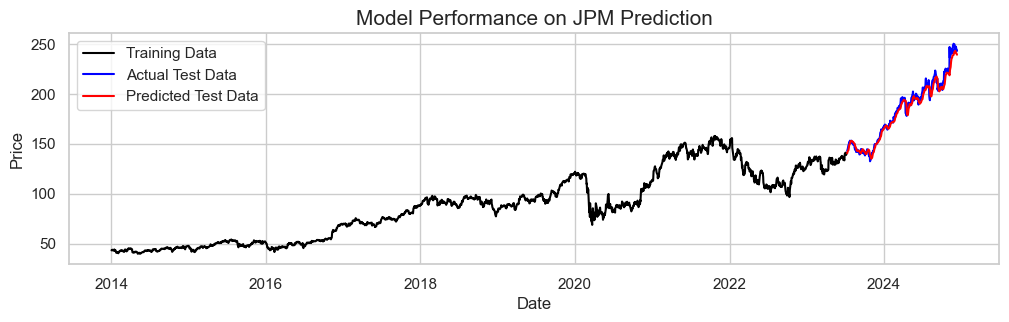

Starting tuning for LLY...
Best Hyperparameters for LLY:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0057 - val_loss: 0.0112
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0010 - val_loss: 0.0357
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 9.0468e-04 - val_loss: 0.0216
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 6.4060e-04 - val_loss: 0.0292
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 6.1870e-04 - val_loss: 0.0159
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 5.0684e-04 - val_loss: 0.0065
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 4.2530e-04 - val_loss: 0.0179
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 4.5304e-04 - val_loss: 0.0103
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 4.2407e-04 - val_loss: 0.0049
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 3.6118e-04 - val_loss: 0.0024
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 3.4155e-04 - val_loss: 0.0050
Epoch 12/50
59/5

<Figure size 640x480 with 0 Axes>

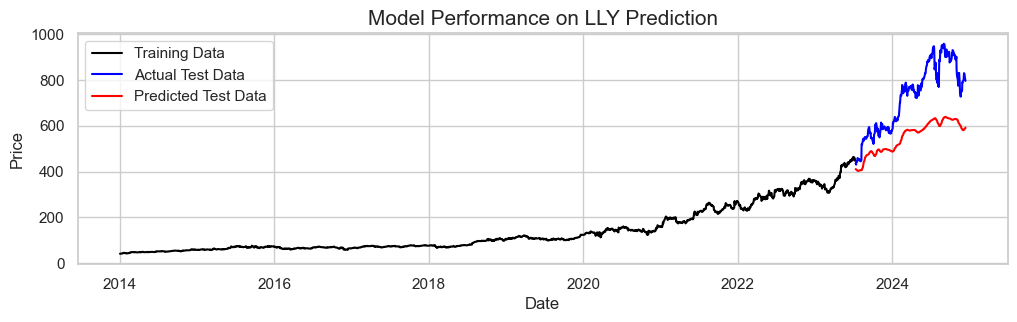

Starting tuning for MA...
Best Hyperparameters for MA:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0614 - val_loss: 0.1529
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0095 - val_loss: 0.1101
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0070 - val_loss: 0.0433
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0051 - val_loss: 0.0117
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0039 - val_loss: 0.0554
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0038 - val_loss: 0.0855
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0037 - val_loss: 0.0547
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.0022 - val_loss: 0.0576
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0026 - val_loss: 0.0181
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step

<Figure size 640x480 with 0 Axes>

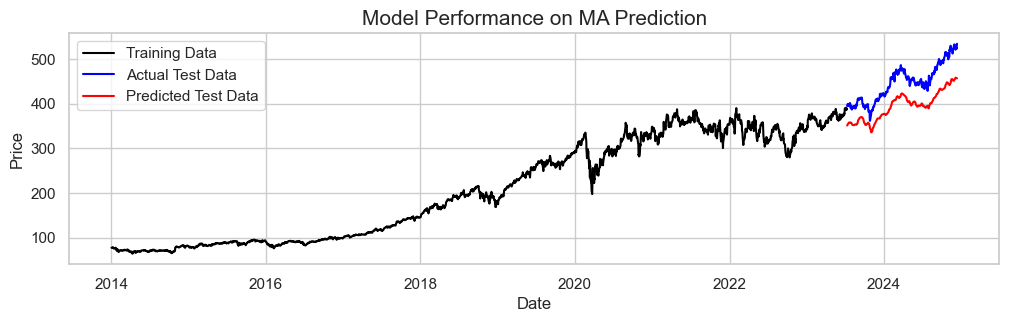

Starting tuning for META...
Best Hyperparameters for META:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0292 - val_loss: 0.0873
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 0.0087 - val_loss: 0.0465
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0048 - val_loss: 0.0274
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0034 - val_loss: 0.0281
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0031 - val_loss: 0.0217
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0024 - val_loss: 0.0297
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0026 - val_loss: 0.0100
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0022 - val_loss: 0.0165
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0017 - val_loss: 0.0192
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 0.0016 - val_loss: 0.0170
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step

<Figure size 640x480 with 0 Axes>

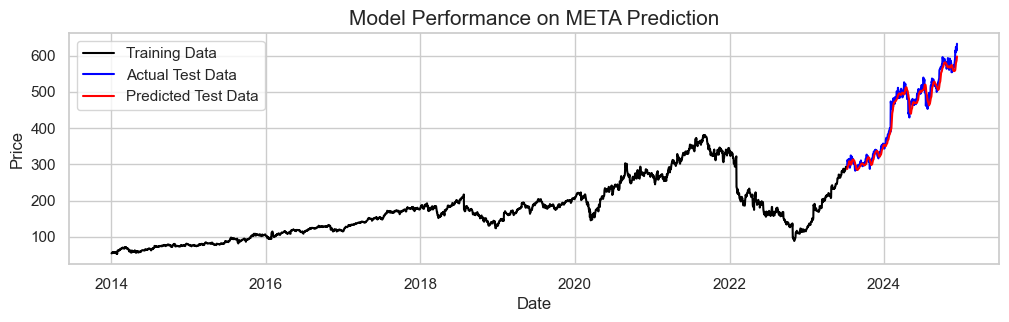

Starting tuning for MSFT...
Best Hyperparameters for MSFT:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0162 - val_loss: 0.1428
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0035 - val_loss: 0.0127
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0019 - val_loss: 0.0399
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0024 - val_loss: 0.0269
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0018 - val_loss: 0.0412
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0014 - val_loss: 0.0262
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0013 - val_loss: 0.0186
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 9.7342e-04 - val_loss: 0.0105
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 7.6783e-04 - val_loss: 0.0250
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 9.5601e-04 - val_loss: 0.0021
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7

<Figure size 640x480 with 0 Axes>

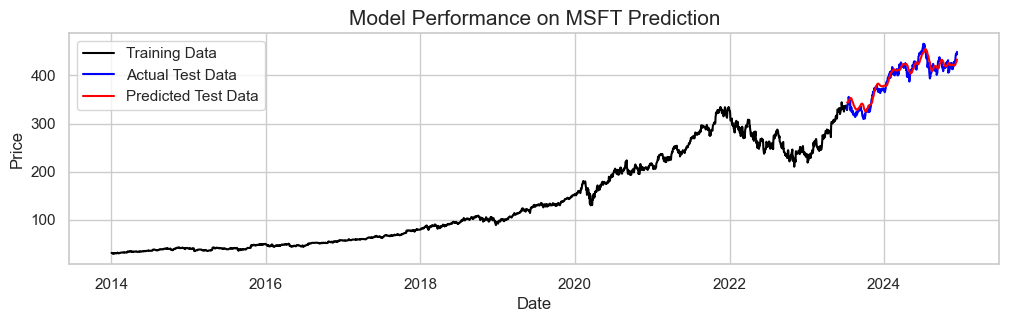

Starting tuning for NVDA...
Best Hyperparameters for NVDA:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.0044 - val_loss: 0.0134
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 6.0144e-04 - val_loss: 0.0128
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 5.7191e-04 - val_loss: 0.0064
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 4.4904e-04 - val_loss: 0.0133
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 4.8449e-04 - val_loss: 0.0053
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 3.0730e-04 - val_loss: 0.0050
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 3.2932e-04 - val_loss: 0.0097
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 3.8865e-04 - val_loss: 0.0097
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 3.0057e-04 - val_loss: 0.0076
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 3.0305e-04 - val_loss: 0.0062
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 2.7138e-04 - val_loss: 0.0055
Epoch 12/50


<Figure size 640x480 with 0 Axes>

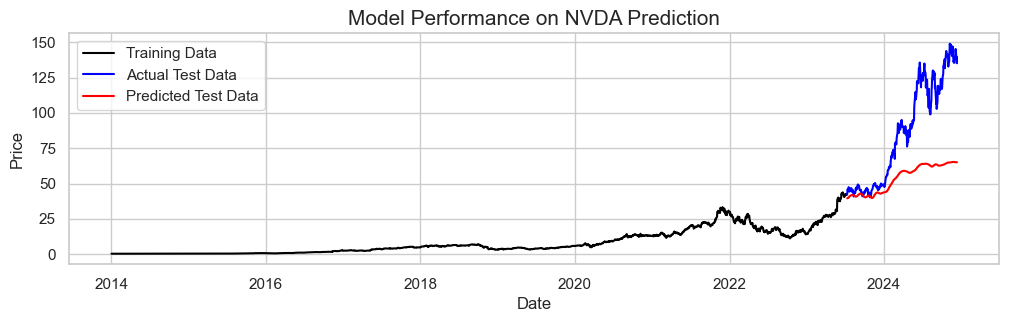

Starting tuning for ORCL...
Best Hyperparameters for ORCL:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0063 - val_loss: 0.0243
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0017 - val_loss: 0.0672
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0010 - val_loss: 0.0178
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 7.9862e-04 - val_loss: 0.0044
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 6.6203e-04 - val_loss: 0.0023
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 8.0887e-04 - val_loss: 0.0037
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 6.8971e-04 - val_loss: 0.0138
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 6.3573e-04 - val_loss: 0.0144
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 6.4781e-04 - val_loss: 0.0086
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 5.7402e-04 - val_loss: 0.0075
Epoch 12/50
59/59 ━━━━━━

<Figure size 640x480 with 0 Axes>

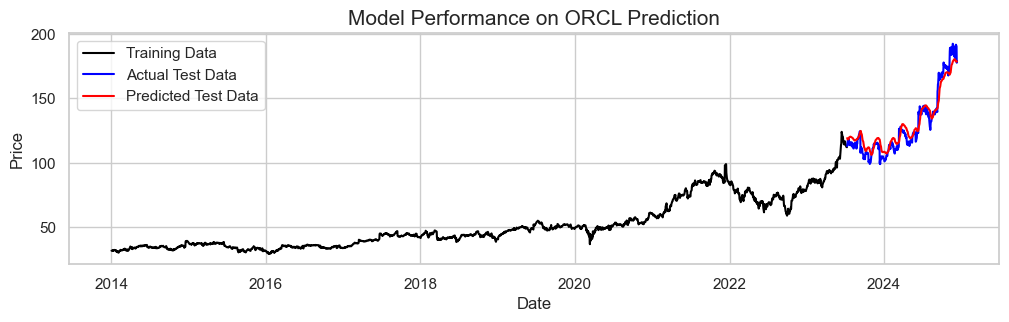

Starting tuning for PG...
Best Hyperparameters for PG:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 0.0310 - val_loss: 0.0028
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0035 - val_loss: 0.0755
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0035 - val_loss: 0.0429
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0026 - val_loss: 0.0199
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0025 - val_loss: 0.0855
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0024 - val_loss: 0.0643
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0020 - val_loss: 0.0336
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0020 - val_loss: 0.0259
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0018 - val_loss: 0.0464
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0016 - val_loss: 0.0538
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step

<Figure size 640x480 with 0 Axes>

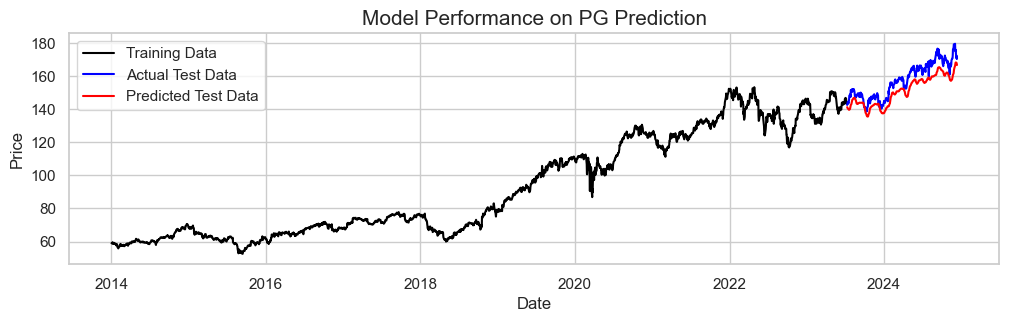

Starting tuning for TSLA...
Best Hyperparameters for TSLA:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 0.0073 - val_loss: 0.1032
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0011 - val_loss: 0.0280
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0013 - val_loss: 0.0187
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 8.9255e-04 - val_loss: 0.0209
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 7.2810e-04 - val_loss: 0.0094
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 7.5687e-04 - val_loss: 0.0146
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 6.4448e-04 - val_loss: 0.0307
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 7.7354e-04 - val_loss: 0.0045
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 5.7567e-04 - val_loss: 0.0070
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 6.5332e-04 - val_loss: 0.0082
Epoch 12/50
59/59 ━━━━━━

<Figure size 640x480 with 0 Axes>

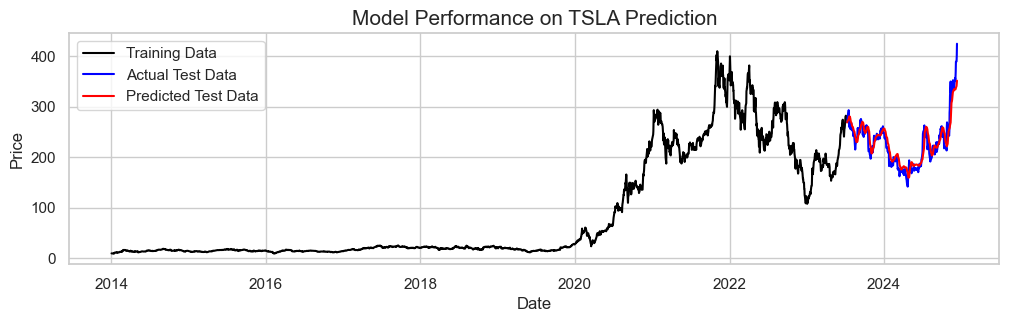

Starting tuning for UNH...
Best Hyperparameters for UNH:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0241 - val_loss: 0.1452
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0042 - val_loss: 0.1147
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0027 - val_loss: 0.0455
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0021 - val_loss: 0.0615
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0018 - val_loss: 0.0178
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0015 - val_loss: 0.0248
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0015 - val_loss: 0.0094
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0012 - val_loss: 0.0528
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0013 - val_loss: 0.0097
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0010 - val_loss: 0.0321
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0011 - val_loss: 0.0191
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step -

<Figure size 640x480 with 0 Axes>

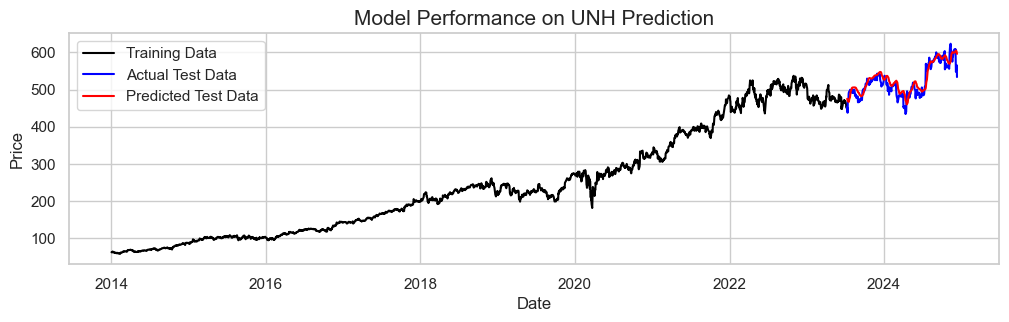

Starting tuning for V...
Best Hyperparameters for V:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.0530 - val_loss: 0.0361
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0072 - val_loss: 0.0162
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0050 - val_loss: 0.0323
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0039 - val_loss: 0.0385
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0033 - val_loss: 0.0077
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0028 - val_loss: 0.0165
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step

<Figure size 640x480 with 0 Axes>

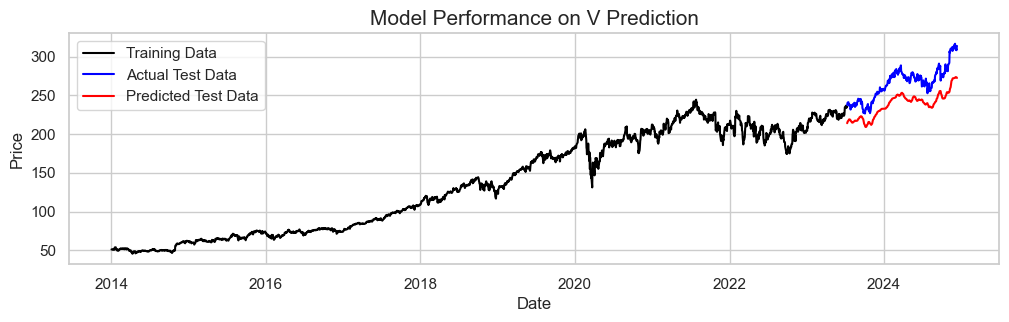

Starting tuning for WMT...
Best Hyperparameters for WMT:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.0394 - val_loss: 0.1551
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0072 - val_loss: 0.0429
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0041 - val_loss: 0.0437
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0040 - val_loss: 0.0703
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0036 - val_loss: 0.0082
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0031 - val_loss: 0.0191
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0021 - val_loss: 0.0072
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0014 - val_loss: 0.0106
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0017 - val_loss: 0.0101
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step

<Figure size 640x480 with 0 Axes>

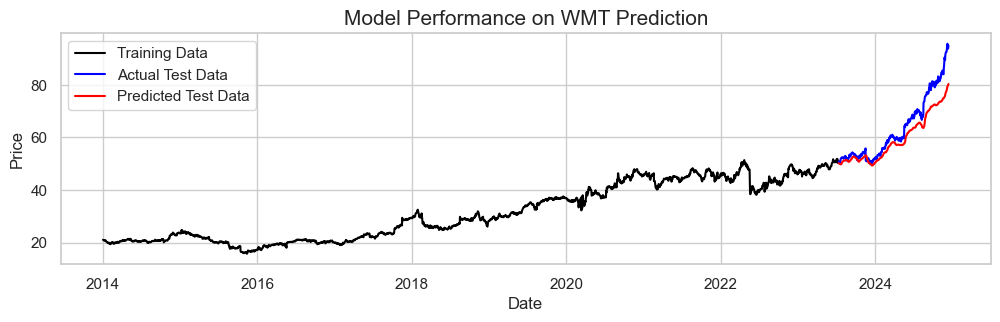

Starting tuning for XOM...
Best Hyperparameters for XOM:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.0222 - val_loss: 0.0052
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0021 - val_loss: 0.0187
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0017 - val_loss: 0.0217
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0011 - val_loss: 0.0202
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - loss: 0.0012 - val_loss: 0.0078
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 9.9064e-04 - val_loss: 0.0033
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/

<Figure size 640x480 with 0 Axes>

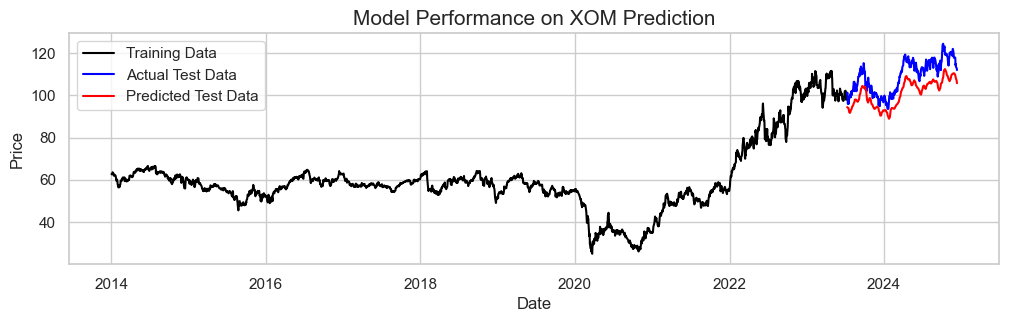

Total time taken for the entire process: 7420.30148935318 seconds


<Figure size 640x480 with 0 Axes>

In [25]:
sp500_results = find_fit_eva(df=sp500, test_size=test_size, results=results, tuner=tuner, define_model=define_model)

**Saving Model**

In [68]:
# sp500_results[0] into a single DataFrame
sp500_results_df = pd.concat(
    [df.assign(stock=stock) for stock, df in sp500_results[0].items()],
    ignore_index=True)

# Export
sp500_results_df.to_csv("../Data/sp500_hyper_df.csv", index=False)

In [54]:
predictions = sp500_results[1]
predictions_df = pd.DataFrame({stock: pred.ravel() for stock, pred in predictions.items()})

# Export
predictions_df.to_csv("../Data/predictions_sp500.csv", index=False)

In [70]:
import keras
import os
models_ = sp500_results[2]

# Loop through each stock model
for stock, model in models_.items():
    model_filename = f'models/{stock}_model.keras' 
    model.save(model_filename)
    print(f"Model for {stock} saved to {model_filename}")

Model for AAPL saved to models/AAPL_model.keras
Model for AMZN saved to models/AMZN_model.keras
Model for AVGO saved to models/AVGO_model.keras
Model for COST saved to models/COST_model.keras
Model for GOOG saved to models/GOOG_model.keras
Model for GOOGL saved to models/GOOGL_model.keras
Model for HD saved to models/HD_model.keras
Model for JPM saved to models/JPM_model.keras
Model for LLY saved to models/LLY_model.keras
Model for MA saved to models/MA_model.keras
Model for META saved to models/META_model.keras
Model for MSFT saved to models/MSFT_model.keras
Model for NVDA saved to models/NVDA_model.keras
Model for ORCL saved to models/ORCL_model.keras
Model for PG saved to models/PG_model.keras
Model for TSLA saved to models/TSLA_model.keras
Model for UNH saved to models/UNH_model.keras
Model for V saved to models/V_model.keras
Model for WMT saved to models/WMT_model.keras
Model for XOM saved to models/XOM_model.keras


**Expected Return**

In [58]:
forecasted_returns_pct_list = []
for column in predictions_df.columns:
    # Correctly get the first and last value using .iloc
    forecasted_returns = (predictions_df[column].iloc[-1] - predictions_df[column].iloc[0]) / predictions_df[column].iloc[0]
    forecasted_returns_pct = forecasted_returns * 100
    forecasted_returns_pct_list.append(forecasted_returns_pct)

# Create a DataFrame from the list
forecasted_returns_df = pd.DataFrame(forecasted_returns_pct_list, index=predictions_df.columns, columns=["Expected Return (%)"])

# Find the top 10 highest returns
top_10_returns = forecasted_returns_df.sort_values(by="Expected Return (%)", ascending=False).head(10)
top_10_returns.to_csv("../Data/top_10_returns_sp500.csv")

# All returns
sp500_returns = forecasted_returns_df.sort_values(by="Expected Return (%)", ascending=False)
sp500_returns.to_csv("../Data/sp500_returns.csv")